# Projeto 1
## Introdução a Data Science
### Alunos
Gabriel de Melo Evangelista (gme@cin.ufpe.br)

Maria Luísa Leandro de Lima (mlll@cin.ufpe.br)
### Tema: Powerlifting
https://openpowerlifting.gitlab.io/opl-csv/bulk-csv-docs.html

- Comparação: Pesos levantados por homem/mulher, raw/singleply, 2 grupos de idade

- ver a diferença de performance de uma pessoa com os anos

- discretizar os pesos usados em exercicios pra dps categorizar usar pra alguma coisa
  - colocar uma coluna pra flag de exercicio falho e remover o sinal negativo da coluna original

- o peso que as pessoas conseguem executar o exercicio é menor que o peso que eles falham

- ver se tem impacto ser tested ou n

- ajeitar a idade bugada pra zero
  
- Criar um plot com o peso levantado com melhores dos equipamentos, separando por idade
  
- Criar um plot com as 4 tentativas de levantamento para ver a melhoria das pessoas

### Imports

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import mean_absolute_percentage_error as mape

### 1. Coleta de dados

In [2]:
df = pd.read_csv('openpowerlifting.csv')

/tmp/ipykernel_8933/3096358404.py:1: DtypeWarning: Columns (33,35,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('openpowerlifting.csv')


In [3]:
df.head()

,Name,Sex,Event,Equipment,Age,AgeClass,BirthYearClass,Division,BodyweightKg,WeightClassKg,...,Tested,Country,State,Federation,ParentFederation,Date,MeetCountry,MeetState,MeetTown,MeetName
0,Alona Vladi,F,SBD,Raw,33.0,24-34,24-39,O,58.30,60,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament
1,Galina Solovyanova,F,SBD,Raw,43.0,40-44,40-49,M1,73.10,75,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament
2,Daniil Voronin,M,SBD,Raw,15.5,16-17,14-18,T,67.40,75,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament
3,Aleksey Krasov,M,SBD,Raw,35.0,35-39,24-39,O,66.65,75,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament
4,Margarita Pleschenkova,M,SBD,Raw,26.5,24-34,24-39,O,72.45,75,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament


In [4]:
df.shape

(2744390, 41)

Observamos que os dados tem cerca de 2.7 milhões de entradas com 41 colunas.

In [5]:
df.columns

Index(['Name', 'Sex', 'Event', 'Equipment', 'Age', 'AgeClass',
       'BirthYearClass', 'Division', 'BodyweightKg', 'WeightClassKg',
       'Squat1Kg', 'Squat2Kg', 'Squat3Kg', 'Squat4Kg', 'Best3SquatKg',
       'Bench1Kg', 'Bench2Kg', 'Bench3Kg', 'Bench4Kg', 'Best3BenchKg',
       'Deadlift1Kg', 'Deadlift2Kg', 'Deadlift3Kg', 'Deadlift4Kg',
       'Best3DeadliftKg', 'TotalKg', 'Place', 'Dots', 'Wilks', 'Glossbrenner',
       'Goodlift', 'Tested', 'Country', 'State', 'Federation',
       'ParentFederation', 'Date', 'MeetCountry', 'MeetState', 'MeetTown',
       'MeetName'],
      dtype='object')

A coluna de "Event" indica 

In [6]:
df['Event'].value_counts()

SBD    1886059
B       627304
D       157510
BD       53965
S        14886
SB        2876
SD        1790
Name: Event, dtype: int64

In [7]:
df['Equipment'].value_counts()

Single-ply    1312406
Raw           1127258
Wraps          177562
Multi-ply      119583
Unlimited        7535
Straps             46
Name: Equipment, dtype: int64

In [8]:
df[~df['Place'].str.isnumeric()]['Place'].value_counts()

DQ    173956
NS     14671
G       7461
DD      1506
Name: Place, dtype: int64

In [9]:
df = df[(df['Place'].str.isnumeric()) & (df['Event']=='SBD') & (df['Equipment'].isin(['Single-ply', 'Raw']))]

In [10]:
df.head()

,Name,Sex,Event,Equipment,Age,AgeClass,BirthYearClass,Division,BodyweightKg,WeightClassKg,...,Tested,Country,State,Federation,ParentFederation,Date,MeetCountry,MeetState,MeetTown,MeetName
0,Alona Vladi,F,SBD,Raw,33.0,24-34,24-39,O,58.30,60,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament
1,Galina Solovyanova,F,SBD,Raw,43.0,40-44,40-49,M1,73.10,75,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament
2,Daniil Voronin,M,SBD,Raw,15.5,16-17,14-18,T,67.40,75,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament
3,Aleksey Krasov,M,SBD,Raw,35.0,35-39,24-39,O,66.65,75,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament
4,Margarita Pleschenkova,M,SBD,Raw,26.5,24-34,24-39,O,72.45,75,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament


### 2. Pré-processamento dos dados

#### 2.1 Análise

In [11]:
df.dtypes

Name                 object
Sex                  object
Event                object
Equipment            object
Age                 float64
AgeClass             object
BirthYearClass       object
Division             object
BodyweightKg        float64
WeightClassKg        object
Squat1Kg            float64
Squat2Kg            float64
Squat3Kg            float64
Squat4Kg            float64
Best3SquatKg        float64
Bench1Kg            float64
Bench2Kg            float64
Bench3Kg            float64
Bench4Kg            float64
Best3BenchKg        float64
Deadlift1Kg         float64
Deadlift2Kg         float64
Deadlift3Kg         float64
Deadlift4Kg         float64
Best3DeadliftKg     float64
TotalKg             float64
Place                object
Dots                float64
Wilks               float64
Glossbrenner        float64
Goodlift            float64
Tested               object
Country              object
State                object
Federation           object
ParentFederation    

In [12]:
types = df.dtypes
columns = pd.DataFrame(df.columns)

In [13]:
# #print(types['Name'])
# columns['isObject'] = df.apply(lambda x: x.dtype == 'object', axis=1)
# columns
# #dictr = dict.fromkeys(neetCat, 'category')
# # dfnaclean2 = dfnaclean.astype({neetCat: 'category'}, errors='raise') 
# FAZER DEPOIS

In [14]:
df['Sex'] = df['Sex'].astype('category')
df['Equipment'] = df['Equipment'].astype('category')
df['Division'] = df['Division'].astype('category')
df['WeightClassKg'] = df['WeightClassKg'].astype('category')
df['Place'] = df['Place'].astype('category')
df['Name'] = df['Name'].astype('category')
df['Event'] = df['Event'].astype('category')

In [15]:
df['Sex'] = df['Sex'].cat.codes
df['EquipmentC'] = df['Equipment'].cat.codes
df['DivisionC'] = df['Division'].cat.codes
df['WeightClassKgC'] = df['WeightClassKg'].cat.codes
df['PlaceC'] = df['Place'].cat.codes
df['NameC'] = df['Name'].cat.codes
df['EventC'] = df['Event'].cat.codes

In [16]:
df.head()

,Name,Sex,Event,Equipment,Age,AgeClass,BirthYearClass,Division,BodyweightKg,WeightClassKg,...,MeetCountry,MeetState,MeetTown,MeetName,EquipmentC,DivisionC,WeightClassKgC,PlaceC,NameC,EventC
0,Alona Vladi,0,SBD,Raw,33.0,24-34,24-39,O,58.30,60,...,Russia,NaN,Bryansk,Open Tournament,0,1865,138,0,23976,0
1,Galina Solovyanova,0,SBD,Raw,43.0,40-44,40-49,M1,73.10,75,...,Russia,NaN,Bryansk,Open Tournament,0,1196,189,0,165932,0
2,Daniil Voronin,1,SBD,Raw,15.5,16-17,14-18,T,67.40,75,...,Russia,NaN,Bryansk,Open Tournament,0,2171,189,0,114094,0
3,Aleksey Krasov,1,SBD,Raw,35.0,35-39,24-39,O,66.65,75,...,Russia,NaN,Bryansk,Open Tournament,0,1865,189,0,15365,0
4,Margarita Pleschenkova,1,SBD,Raw,26.5,24-34,24-39,O,72.45,75,...,Russia,NaN,Bryansk,Open Tournament,0,1865,189,0,300972,0


In [17]:
df.isna().sum(axis=0)

Name                      0
Sex                       0
Event                     0
Equipment                 0
Age                  726249
AgeClass             551205
BirthYearClass       681413
Division               1173
BodyweightKg          11885
WeightClassKg          8586
Squat1Kg             989817
Squat2Kg             994541
Squat3Kg            1007495
Squat4Kg            1519175
Best3SquatKg           9331
Bench1Kg             989986
Bench2Kg             993814
Bench3Kg            1007523
Bench4Kg            1519683
Best3BenchKg           9315
Deadlift1Kg          989600
Deadlift2Kg          996298
Deadlift3Kg         1015185
Deadlift4Kg         1516988
Best3DeadliftKg        9277
TotalKg                   0
Place                     0
Dots                  11885
Wilks                 11885
Glossbrenner          11885
Goodlift              12790
Tested               244023
Country              799232
State               1213230
Federation                0
ParentFederation    

In [18]:
dfnaclean = df.dropna(thresh=0.7*len(df), axis=1)
dfnaclean['Age'] = df['Age']

/tmp/ipykernel_8933/1516559056.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfnaclean['Age'] = df['Age']


In [19]:
dfnaclean.isnull().sum()

Name                    0
Sex                     0
Event                   0
Equipment               0
Division             1173
BodyweightKg        11885
WeightClassKg        8586
Best3SquatKg         9331
Best3BenchKg         9315
Best3DeadliftKg      9277
TotalKg                 0
Place                   0
Dots                11885
Wilks               11885
Glossbrenner        11885
Goodlift            12790
Tested             244023
Federation              0
Date                    0
MeetCountry             0
MeetState          321016
MeetTown           195186
MeetName                0
EquipmentC              0
DivisionC               0
WeightClassKgC          0
PlaceC                  0
NameC                   0
EventC                  0
Age                726249
dtype: int64

In [20]:
dfnaclean.head()

,Name,Sex,Event,Equipment,Division,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,...,MeetState,MeetTown,MeetName,EquipmentC,DivisionC,WeightClassKgC,PlaceC,NameC,EventC,Age
0,Alona Vladi,0,SBD,Raw,O,58.30,60,80.0,60.0,107.5,...,NaN,Bryansk,Open Tournament,0,1865,138,0,23976,0,33.0
1,Galina Solovyanova,0,SBD,Raw,M1,73.10,75,105.0,67.5,110.0,...,NaN,Bryansk,Open Tournament,0,1196,189,0,165932,0,43.0
2,Daniil Voronin,1,SBD,Raw,T,67.40,75,100.0,62.5,105.0,...,NaN,Bryansk,Open Tournament,0,2171,189,0,114094,0,15.5
3,Aleksey Krasov,1,SBD,Raw,O,66.65,75,137.5,122.5,170.0,...,NaN,Bryansk,Open Tournament,0,1865,189,0,15365,0,35.0
4,Margarita Pleschenkova,1,SBD,Raw,O,72.45,75,90.0,50.0,125.0,...,NaN,Bryansk,Open Tournament,0,1865,189,0,300972,0,26.5


In [21]:
dfnaclean[dfnaclean.duplicated()]

,Name,Sex,Event,Equipment,Division,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,...,MeetState,MeetTown,MeetName,EquipmentC,DivisionC,WeightClassKgC,PlaceC,NameC,EventC,Age
4340,Alexis Carvalho,1,SBD,Raw,Open,81.80,82.5,220.00,157.50,250.00,...,NaN,NaN,Campeonato Nacional de Powerlifting,0,1868,216,0,20680,0,22.0
81611,Kevin Gingerich,1,SBD,Raw,Open,71.94,75,154.22,115.67,183.70,...,NC,Charlotte,Junior & Senior National Powerlifting Champion...,0,1868,189,32,261685,0,32.0
92867,Mitch Booyse,1,SBD,Raw,Juniors,53.00,53,97.50,60.00,112.50,...,NaN,Johannesburg,Gauteng Raw Powerlifting Championships,0,871,113,0,328828,0,15.5
107583,Henrik Vestergaard,1,SBD,Single-ply,Open,67.50,67.5,190.00,122.50,207.50,...,NaN,Thisted,DM A,1,1868,162,0,181733,0,33.5
113729,Kim Andersen,1,SBD,Single-ply,Open,100.00,100,280.00,180.00,300.00,...,NaN,Horsens,DM A,1,1868,2,0,263608,0,28.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657503,Denzell Perry,1,SBD,Single-ply,Boys,94.17,99.7,156.49,115.67,165.56,...,TX,Anna,Anna High School Meet,1,156,276,98,125065,0,NaN
2657508,Victor Martinez,1,SBD,Single-ply,Boys,95.25,99.7,115.67,92.99,156.49,...,TX,Anna,Anna High School Meet,1,156,276,23,452070,0,NaN
2657532,Quinton Carroll,1,SBD,Single-ply,Boys,113.49,124.7,179.17,88.45,174.63,...,TX,Anna,Anna High School Meet,1,156,50,65,365794,0,NaN
2657534,Dario Richardson,1,SBD,Single-ply,Boys,120.47,124.7,106.59,79.38,129.27,...,TX,Anna,Anna High School Meet,1,156,50,76,115596,0,NaN


In [22]:
dfnaclean.drop_duplicates(inplace=True)

/tmp/ipykernel_8933/1111256310.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfnaclean.drop_duplicates(inplace=True)


In [23]:
dfnaclean[dfnaclean.duplicated()]

,Name,Sex,Event,Equipment,Division,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,...,MeetState,MeetTown,MeetName,EquipmentC,DivisionC,WeightClassKgC,PlaceC,NameC,EventC,Age


In [24]:
dfnaclean = dfnaclean.drop(['MeetState','MeetTown'], axis=1)

In [25]:
dfnaclean.shape

(1521581, 28)

#### 2.2 Inserindo dados ausentes em mais de uma coluna

In [26]:
dfnaclean.columns

Index(['Name', 'Sex', 'Event', 'Equipment', 'Division', 'BodyweightKg',
       'WeightClassKg', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg',
       'TotalKg', 'Place', 'Dots', 'Wilks', 'Glossbrenner', 'Goodlift',
       'Tested', 'Federation', 'Date', 'MeetCountry', 'MeetName', 'EquipmentC',
       'DivisionC', 'WeightClassKgC', 'PlaceC', 'NameC', 'EventC', 'Age'],
      dtype='object')

In [27]:
incomplete_mask = ['Sex', 'EquipmentC', 'DivisionC', 'BodyweightKg', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg', 'TotalKg', 'PlaceC', 'Dots', 'Wilks', 'Glossbrenner', 'Goodlift']

In [28]:
df_complete = dfnaclean[incomplete_mask].dropna().sample(10000).reset_index(drop=True)
df_incomplete = df_complete.copy()

In [29]:
for x in incomplete_mask[3:]:
    df_incomplete[x][df_incomplete.sample(1000).index] = np.NaN

/tmp/ipykernel_8933/2100750748.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_incomplete[x][df_incomplete.sample(1000).index] = np.NaN
/tmp/ipykernel_8933/2100750748.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_incomplete[x][df_incomplete.sample(1000).index] = np.NaN
/tmp/ipykernel_8933/2100750748.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_incomplete[x][df_incomplete.sample(1000).index] = np.NaN
/tmp/ipyke

In [30]:
df_incomplete.isna().sum()

Sex                   0
EquipmentC            0
DivisionC             0
BodyweightKg       1000
Best3SquatKg       1000
Best3BenchKg       1000
Best3DeadliftKg    1000
TotalKg            1000
PlaceC             1000
Dots               1000
Wilks              1000
Glossbrenner       1000
Goodlift           1000
dtype: int64

In [31]:
df_incomplete.sample(10)

,Sex,EquipmentC,DivisionC,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,PlaceC,Dots,Wilks,Glossbrenner,Goodlift
1442,1,1,156,114.08,204.12,122.47,158.76,485.34,65.0,283.64,282.62,270.45,47.86
4794,1,1,1178,90.00,227.50,160.00,205.00,592.50,0.0,383.11,378.25,362.51,65.38
6005,0,1,751,128.64,176.90,81.65,145.15,403.70,0.0,318.21,318.86,269.23,56.29
4122,1,1,2244,NaN,115.00,60.00,130.00,305.00,32.0,211.01,NaN,201.40,36.12
5204,0,1,751,88.99,106.59,61.23,104.33,272.16,76.0,NaN,NaN,205.60,NaN
7983,1,1,871,124.30,290.00,120.00,NaN,652.50,0.0,370.47,372.25,356.39,62.23
4422,1,0,2041,82.50,180.00,157.50,215.00,552.50,32.0,374.26,370.12,356.13,76.71
5651,1,1,156,NaN,108.86,77.11,163.29,349.27,1.0,NaN,237.90,229.19,41.13
8175,0,1,751,53.71,61.23,31.75,70.31,163.29,33.0,194.65,198.51,175.77,32.53
4782,1,1,156,81.37,215.46,129.27,213.19,557.92,NaN,380.92,376.89,362.87,65.18


In [33]:
import fancyimpute as fi
df_SimpleFill = pd.DataFrame(data=fi.SimpleFill().fit_transform(df_incomplete)[0:,0:], columns=incomplete_mask)
sf_mape = mape(df_SimpleFill, df_complete)

In [34]:
df_KNN = pd.DataFrame(data=fi.KNN(k=5).fit_transform(df_incomplete)[0:,0:], columns=incomplete_mask)
knn_mape = mape(df_KNN, df_complete)

Imputing row 1/10000 with 0 missing, elapsed time: 69.913
Imputing row 101/10000 with 1 missing, elapsed time: 69.975
Imputing row 201/10000 with 0 missing, elapsed time: 70.018
Imputing row 301/10000 with 1 missing, elapsed time: 70.042
Imputing row 401/10000 with 1 missing, elapsed time: 70.074
Imputing row 501/10000 with 0 missing, elapsed time: 70.095
Imputing row 601/10000 with 1 missing, elapsed time: 70.112
Imputing row 701/10000 with 1 missing, elapsed time: 70.127
Imputing row 801/10000 with 2 missing, elapsed time: 70.151
Imputing row 901/10000 with 2 missing, elapsed time: 70.167
Imputing row 1001/10000 with 1 missing, elapsed time: 70.183
Imputing row 1101/10000 with 4 missing, elapsed time: 70.199
Imputing row 1201/10000 with 1 missing, elapsed time: 70.217
Imputing row 1301/10000 with 0 missing, elapsed time: 70.231
Imputing row 1401/10000 with 2 missing, elapsed time: 70.247
Imputing row 1501/10000 with 1 missing, elapsed time: 70.262
Imputing row 1601/10000 with 0 missi

In [35]:
df_SoftImpute = pd.DataFrame(data=fi.SoftImpute().fit_transform(df_incomplete)[0:,0:], columns=incomplete_mask)
si_mape = mape(df_SoftImpute, df_complete)

[SoftImpute] Max Singular Value of X_init = 151191.607205
[SoftImpute] Iter 1: observed MAE=15.542316 rank=10
[SoftImpute] Iter 2: observed MAE=15.772011 rank=8
[SoftImpute] Iter 3: observed MAE=15.778611 rank=7
[SoftImpute] Iter 4: observed MAE=15.737227 rank=7
[SoftImpute] Iter 5: observed MAE=15.672619 rank=6
[SoftImpute] Iter 6: observed MAE=14.978521 rank=4
[SoftImpute] Iter 7: observed MAE=14.562531 rank=4
[SoftImpute] Iter 8: observed MAE=14.354340 rank=4
[SoftImpute] Iter 9: observed MAE=14.243868 rank=4
[SoftImpute] Iter 10: observed MAE=14.183630 rank=4
[SoftImpute] Iter 11: observed MAE=14.150044 rank=4
[SoftImpute] Iter 12: observed MAE=14.130626 rank=4
[SoftImpute] Iter 13: observed MAE=14.119198 rank=4
[SoftImpute] Iter 14: observed MAE=14.112324 rank=4
[SoftImpute] Iter 15: observed MAE=14.108058 rank=4
[SoftImpute] Iter 16: observed MAE=14.105383 rank=4
[SoftImpute] Iter 17: observed MAE=14.103694 rank=4
[SoftImpute] Stopped after iteration 17 for lambda=3023.832144


In [36]:
df_IterativeImputer = pd.DataFrame(data=fi.IterativeImputer(max_iter=100).fit_transform(df_incomplete)[0:,0:], columns=incomplete_mask)
ii_mape = mape(df_IterativeImputer, df_complete)

In [37]:
pd.DataFrame({'SimpleFill': sf_mape, 'KNN': knn_mape, 'IterativeImputer': ii_mape, 'SoftImpute': sf_mape})

ValueError: If using all scalar values, you must pass an index

In [ ]:
df_incomplete.describe()

,Sex,EquipmentC,DivisionC,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,PlaceC,Dots,Wilks,Glossbrenner,Goodlift
count,10000.000000,10000.000000,10000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,0.723300,0.620200,1133.017400,81.513048,170.505379,107.507050,184.397564,462.202381,33.200333,342.890389,342.256314,322.594500,62.751386
std,0.447389,0.485361,733.252306,21.941772,63.393582,46.137618,58.661865,162.333677,31.373949,78.999757,78.185871,76.596857,15.244049
min,0.000000,0.000000,-1.000000,35.400000,20.000000,15.000000,25.000000,77.110000,0.000000,92.660000,94.050000,83.190000,16.970000
25%,0.000000,0.000000,341.000000,65.300000,120.200000,70.000000,138.350000,331.120000,0.000000,288.350000,288.595000,269.030000,51.507500
50%,1.000000,1.000000,1134.000000,80.000000,167.500000,104.780000,182.500000,455.860000,32.000000,338.915000,339.105000,320.125000,62.370000
75%,1.000000,1.000000,1868.000000,94.800000,212.500000,137.500000,227.500000,574.100000,54.000000,392.742500,391.322500,371.197500,73.687500
max,1.000000,1.000000,2428.000000,195.000000,453.590000,371.000000,374.210000,1086.000000,109.000000,631.740000,638.440000,592.010000,118.480000


#### 2.3 Limpeza final dos dados

In [40]:
dfnaclean.columns


Index(['Name', 'Sex', 'Event', 'Equipment', 'Division', 'BodyweightKg',
       'WeightClassKg', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg',
       'TotalKg', 'Place', 'Dots', 'Wilks', 'Glossbrenner', 'Goodlift',
       'Tested', 'Federation', 'Date', 'MeetCountry', 'MeetName', 'EquipmentC',
       'DivisionC', 'WeightClassKgC', 'PlaceC', 'NameC', 'EventC', 'Age'],
      dtype='object')

In [41]:
dfnaclean.drop(["MeetCountry", "MeetName", "Tested", "Federation", "Date"], axis = 1, inplace=True)
dfnaclean = dfnaclean[dfnaclean['Age'].notna()]

In [42]:
dfnaclean.dtypes

Name               category
Sex                    int8
Event              category
Equipment          category
Division           category
BodyweightKg        float64
WeightClassKg      category
Best3SquatKg        float64
Best3BenchKg        float64
Best3DeadliftKg     float64
TotalKg             float64
Place              category
Dots                float64
Wilks               float64
Glossbrenner        float64
Goodlift            float64
EquipmentC             int8
DivisionC             int16
WeightClassKgC        int16
PlaceC                 int8
NameC                 int32
EventC                 int8
Age                 float64
dtype: object

### 3. Estatisticas descritivas dos dados e visualização

#### 3.1 Estatísticas descritivas

##### 3.1.1 Estatísticas Gerais

In [43]:
dfnaclean.columns

Index(['Name', 'Sex', 'Event', 'Equipment', 'Division', 'BodyweightKg',
       'WeightClassKg', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg',
       'TotalKg', 'Place', 'Dots', 'Wilks', 'Glossbrenner', 'Goodlift',
       'EquipmentC', 'DivisionC', 'WeightClassKgC', 'PlaceC', 'NameC',
       'EventC', 'Age'],
      dtype='object')

In [44]:
dfnaclean.describe()

,Sex,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Dots,Wilks,Glossbrenner,Goodlift,EquipmentC,DivisionC,WeightClassKgC,PlaceC,NameC,EventC,Age
count,795929.000000,792827.000000,794620.000000,794632.000000,794643.000000,795929.000000,792827.000000,792827.000000,792827.000000,792062.000000,795929.000000,795929.000000,795929.000000,795929.000000,795929.000000,795929.0,795929.000000
mean,0.702151,81.888677,177.811925,115.501717,195.860997,489.093882,362.475563,361.055080,339.323178,68.589109,0.398298,1447.868428,146.851409,27.529301,244148.723227,0.0,28.155920
std,0.457341,21.882872,67.692854,49.551394,61.723131,173.085477,81.719113,81.382283,79.930931,14.617732,0.489548,590.131674,80.113791,29.582510,140445.832058,0.0,12.095259
min,0.000000,17.690000,4.700000,4.000000,7.500000,24.000000,28.360000,28.230000,27.320000,4.860000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.0,0.000000
25%,0.000000,65.790000,125.000000,75.000000,145.000000,347.500000,307.660000,306.400000,284.430000,58.920000,0.000000,885.000000,74.000000,0.000000,124911.000000,0.0,19.500000
50%,1.000000,80.600000,175.000000,115.000000,199.600000,487.610000,360.900000,359.310000,338.230000,69.150000,0.000000,1742.000000,162.000000,32.000000,250196.000000,0.0,24.500000
75%,1.000000,94.700000,222.500000,150.000000,240.000000,610.000000,415.510000,413.730000,392.140000,78.720000,1.000000,1868.000000,216.000000,43.000000,363371.000000,0.0,34.000000
max,2.000000,260.000000,517.500000,435.000000,465.000000,1296.000000,731.310000,722.020000,691.990000,136.800000,1.000000,2428.000000,277.000000,119.000000,477323.000000,0.0,95.500000


In [45]:
dfnaclean.cov()

,Sex,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Dots,Wilks,Glossbrenner,Goodlift,EquipmentC,DivisionC,WeightClassKgC,PlaceC,NameC,EventC,Age
Sex,0.209161,4.375785,18.220006,14.799628,18.549169,51.531814,8.445373,8.235158,13.574039,1.344852,0.017974,5.845885e+01,-3.672502,1.212523,3.936411e+02,0.0,-0.042001
BodyweightKg,4.375785,478.860084,931.127498,709.098264,857.320169,2496.713541,354.218637,326.061876,382.242961,72.514601,-0.455890,1.144743e+03,-576.659639,-15.708917,-2.356785e+04,0.0,44.646678
Best3SquatKg,18.220006,931.127498,4582.322545,3047.254293,3819.691687,11448.378154,4423.123836,4347.622004,4535.010971,712.182921,8.980837,7.055366e+03,-1125.108533,33.829064,7.718776e+04,0.0,27.242458
Best3BenchKg,14.799628,709.098264,3047.254293,2455.340611,2687.212061,8189.124045,2882.662314,2830.098117,3029.945801,471.970809,5.153690,6.155494e+03,-899.630172,11.941061,7.740615e+04,0.0,60.601536
Best3DeadliftKg,18.549169,857.320169,3819.691687,2687.212061,3809.744883,10316.087231,3747.738626,3663.764752,3906.485434,667.743648,3.021355,6.801210e+03,-886.415003,-9.192529,4.701233e+04,0.0,58.583805
TotalKg,51.531814,2496.713541,11448.378154,8189.124045,10316.087231,29958.582358,11061.602716,10849.376632,11477.744113,1853.737282,17.118464,2.000747e+04,-2908.202597,34.922929,2.025070e+05,0.0,147.303150
Dots,8.445373,354.218637,4423.123836,2882.662314,3747.738626,11061.602716,6678.013355,6638.420571,6431.181343,1084.397988,12.436597,6.580511e+03,-501.403287,-71.123574,1.828707e+05,0.0,5.816456
Wilks,8.235158,326.061876,4347.622004,2830.098117,3663.764752,10849.376632,6638.420571,6623.075917,6415.945925,1072.902565,12.644933,6.600394e+03,-628.225045,-75.534511,1.936115e+05,0.0,-0.195747
Glossbrenner,13.574039,382.242961,4535.010971,3029.945801,3906.485434,11477.744113,6431.181343,6415.945925,6388.953651,1035.751427,12.499360,7.782822e+03,-652.342356,-34.273722,1.971513e+05,0.0,-7.123583
Goodlift,1.344852,72.514601,712.182921,471.970809,667.743648,1853.737282,1084.397988,1072.902565,1035.751427,213.678082,-0.680318,9.439191e+02,-54.808000,-37.173770,1.151282e+03,0.0,6.000247


In [46]:
dfnaclean.corr()

,Sex,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Dots,Wilks,Glossbrenner,Goodlift,EquipmentC,DivisionC,WeightClassKgC,PlaceC,NameC,EventC,Age
Sex,1.000000,0.437113,0.588408,0.652921,0.656963,0.650991,0.225911,0.221200,0.371224,0.201148,0.080282,0.216601,-0.100234,0.089622,0.006128,NaN,-0.007593
BodyweightKg,0.437113,1.000000,0.630406,0.655408,0.635598,0.660710,0.198081,0.183091,0.218535,0.227186,-0.042588,0.088631,-0.329415,-0.024257,-0.007666,NaN,0.168706
Best3SquatKg,0.588408,0.630406,1.000000,0.908472,0.914190,0.977110,0.802133,0.791694,0.840793,0.723292,0.271077,0.176625,-0.207453,0.016891,0.008118,NaN,0.033270
Best3BenchKg,0.652921,0.655408,0.908472,1.000000,0.878614,0.954785,0.713633,0.703512,0.766852,0.654059,0.212507,0.210510,-0.226606,0.008145,0.011122,NaN,0.101103
Best3DeadliftKg,0.656963,0.635598,0.914190,0.878614,1.000000,0.965626,0.744263,0.730590,0.793111,0.742972,0.100015,0.186727,-0.179249,-0.005034,0.005423,NaN,0.078463
TotalKg,0.650991,0.660710,0.977110,0.954785,0.965626,1.000000,0.783864,0.772007,0.831549,0.735642,0.202027,0.195877,-0.209728,0.006820,0.008330,NaN,0.070362
Dots,0.225911,0.198081,0.802133,0.713633,0.744263,0.783864,1.000000,0.998185,0.984583,0.910054,0.311109,0.136433,-0.076699,-0.029409,0.015929,NaN,0.005885
Wilks,0.221200,0.183091,0.791694,0.703512,0.730590,0.772007,0.998185,1.000000,0.986316,0.903826,0.317630,0.137412,-0.096497,-0.031362,0.016935,NaN,-0.000199
Glossbrenner,0.371224,0.218535,0.840793,0.766852,0.793111,0.831549,0.984583,0.986316,1.000000,0.888022,0.319675,0.164970,-0.102021,-0.014489,0.017557,NaN,-0.007369
Goodlift,0.201148,0.227186,0.723292,0.654059,0.742972,0.735642,0.910054,0.903826,0.888022,1.000000,-0.095133,0.109447,-0.046860,-0.085921,0.000561,NaN,0.033963


##### 3.1.2 Estatísticas de Idade

In [47]:
dfnaclean['Age'].describe()

count    795929.000000
mean         28.155920
std          12.095259
min           0.000000
25%          19.500000
50%          24.500000
75%          34.000000
max          95.500000
Name: Age, dtype: float64

<AxesSubplot:>

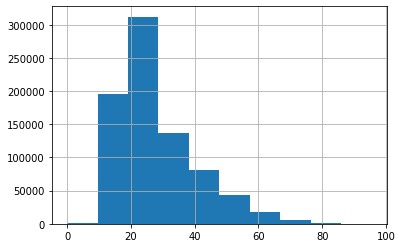

In [48]:
dfnaclean.Age.hist() # não é simetrico

<AxesSubplot:>

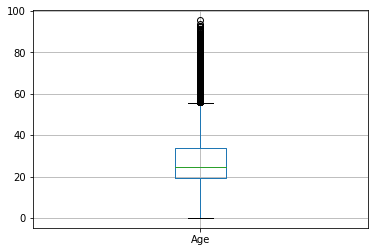

In [49]:
dfnaclean.boxplot(column=['Age'])

In [50]:
## Removendo os outliers e revendo a correlação
dfnaclean[(dfnaclean['Age'] > 18) & (dfnaclean['Age'] < 55)].corr()

,Sex,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Dots,Wilks,Glossbrenner,Goodlift,EquipmentC,DivisionC,WeightClassKgC,PlaceC,NameC,EventC,Age
Sex,1.000000,0.477734,0.651844,0.713592,0.728400,0.720219,0.284043,0.278126,0.432757,0.260614,0.113896,0.233794,-0.132882,0.101651,0.000604,NaN,-0.055003
BodyweightKg,0.477734,1.000000,0.621199,0.647393,0.624164,0.652376,0.150853,0.141338,0.188607,0.169607,-0.006480,0.138611,-0.381288,-0.016916,-0.010870,NaN,0.121183
Best3SquatKg,0.651844,0.621199,1.000000,0.905682,0.907729,0.976452,0.784293,0.774718,0.831518,0.689348,0.351159,0.241285,-0.251163,0.020641,0.006831,NaN,-0.034276
Best3BenchKg,0.713592,0.647393,0.905682,1.000000,0.867076,0.952417,0.690712,0.682051,0.754712,0.609274,0.303726,0.263398,-0.269813,0.017426,0.007392,NaN,0.023463
Best3DeadliftKg,0.728400,0.624164,0.907729,0.867076,1.000000,0.961474,0.713826,0.701166,0.775154,0.705879,0.176384,0.242828,-0.226742,0.002806,-0.000438,NaN,-0.023311
TotalKg,0.720219,0.652376,0.976452,0.952417,0.961474,1.000000,0.761339,0.750593,0.820042,0.697582,0.288447,0.256989,-0.257009,0.013868,0.004697,NaN,-0.014593
Dots,0.284043,0.150853,0.784293,0.690712,0.713826,0.761339,1.000000,0.997984,0.983455,0.891333,0.416203,0.198404,-0.097531,-0.034358,0.015938,NaN,-0.073451
Wilks,0.278126,0.141338,0.774718,0.682051,0.701166,0.750593,0.997984,1.000000,0.984925,0.885617,0.420021,0.197917,-0.117614,-0.037376,0.017168,NaN,-0.075054
Glossbrenner,0.432757,0.188607,0.831518,0.754712,0.775154,0.820042,0.983455,0.984925,1.000000,0.871036,0.417399,0.223954,-0.124994,-0.017034,0.016676,NaN,-0.084157
Goodlift,0.260614,0.169607,0.689348,0.609274,0.705879,0.697582,0.891333,0.885617,0.871036,1.000000,-0.028362,0.148840,-0.063201,-0.092612,-0.005476,NaN,-0.080150


##### 3.1.3 Estatísticas de Peso coporal

In [51]:
dfnaclean['BodyweightKg'].describe()

count    792827.000000
mean         81.888677
std          21.882872
min          17.690000
25%          65.790000
50%          80.600000
75%          94.700000
max         260.000000
Name: BodyweightKg, dtype: float64

<AxesSubplot:>

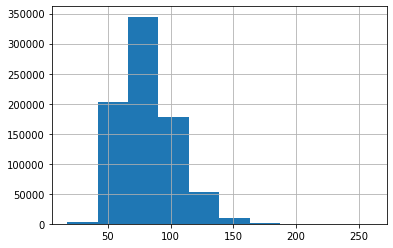

In [52]:
dfnaclean.BodyweightKg.hist()

<AxesSubplot:>

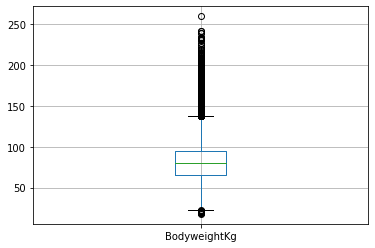

In [53]:
dfnaclean.boxplot(column=['BodyweightKg'])

In [54]:
dfnaclean[(dfnaclean['BodyweightKg'] > 25) & (dfnaclean['BodyweightKg'] < 140)].corr()

,Sex,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Dots,Wilks,Glossbrenner,Goodlift,EquipmentC,DivisionC,WeightClassKgC,PlaceC,NameC,EventC,Age
Sex,1.000000,0.452295,0.591802,0.657741,0.658809,0.654386,0.224823,0.218945,0.370491,0.200732,0.080570,0.215850,-0.088204,0.092996,0.006248,NaN,-0.010248
BodyweightKg,0.452295,1.000000,0.630244,0.658115,0.646113,0.665099,0.199732,0.175091,0.215925,0.235401,-0.042411,0.089657,-0.308751,-0.010192,-0.007998,NaN,0.173750
Best3SquatKg,0.591802,0.630244,1.000000,0.907909,0.914665,0.976917,0.804735,0.791199,0.842324,0.726577,0.272259,0.175774,-0.187422,0.024855,0.007832,NaN,0.029725
Best3BenchKg,0.657741,0.658115,0.907909,1.000000,0.879500,0.954641,0.714714,0.701359,0.767131,0.656866,0.211753,0.210100,-0.206974,0.015943,0.010887,NaN,0.097869
Best3DeadliftKg,0.658809,0.646113,0.914665,0.879500,1.000000,0.966199,0.744035,0.728048,0.792263,0.744106,0.098506,0.184820,-0.161880,0.001411,0.005078,NaN,0.075563
TotalKg,0.654386,0.665099,0.976917,0.954641,0.966199,1.000000,0.785021,0.770203,0.831842,0.738170,0.201383,0.194725,-0.189986,0.014441,0.008014,NaN,0.067040
Dots,0.224823,0.199732,0.804735,0.714714,0.744035,0.785021,1.000000,0.998366,0.984544,0.909738,0.310919,0.135104,-0.071482,-0.028742,0.015738,NaN,0.004900
Wilks,0.218945,0.175091,0.791199,0.701359,0.728048,0.770203,0.998366,1.000000,0.986127,0.903726,0.318083,0.135806,-0.089148,-0.030035,0.016784,NaN,-0.001764
Glossbrenner,0.370491,0.215925,0.842324,0.767131,0.792263,0.831842,0.984544,0.986127,1.000000,0.887799,0.320057,0.163610,-0.094617,-0.013014,0.017400,NaN,-0.009058
Goodlift,0.200732,0.235401,0.726577,0.656866,0.744106,0.738170,0.909738,0.903726,0.887799,1.000000,-0.096312,0.107533,-0.042716,-0.085267,0.000317,NaN,0.033650


##### 3.1.4 Estatísticas de peso levantado em agachamento, supino e deadlift

In [55]:
dfnaclean[['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg']].describe()

,Best3SquatKg,Best3BenchKg,Best3DeadliftKg
count,794620.000000,794632.000000,794643.000000
mean,177.811925,115.501717,195.860997
std,67.692854,49.551394,61.723131
min,4.700000,4.000000,7.500000
25%,125.000000,75.000000,145.000000
50%,175.000000,115.000000,199.600000
75%,222.500000,150.000000,240.000000
max,517.500000,435.000000,465.000000


<AxesSubplot:>

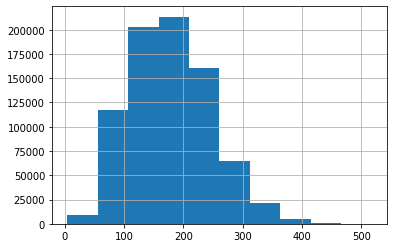

In [56]:
dfnaclean.Best3SquatKg.hist()

<AxesSubplot:>

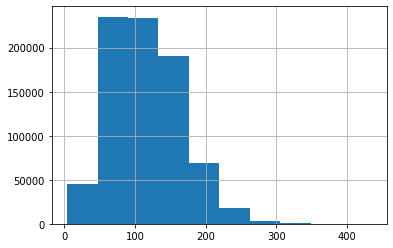

In [57]:
dfnaclean.Best3BenchKg.hist()

<AxesSubplot:>

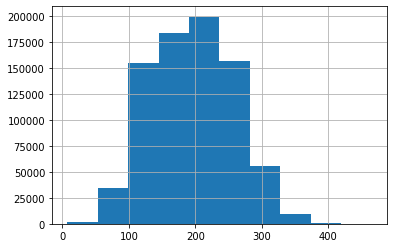

In [58]:
dfnaclean.Best3DeadliftKg.hist()

<AxesSubplot:>

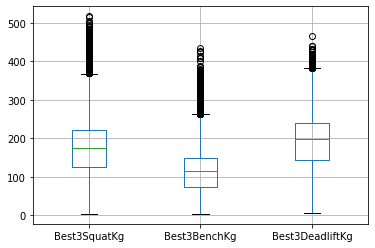

In [59]:
dfnaclean.boxplot(column=['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg'])

In [60]:
dfnaclean[(dfnaclean['Best3SquatKg'] < 380) & (dfnaclean['Best3BenchKg'] < 280) & (dfnaclean['Best3DeadliftKg'] < 390)].corr()[['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg']]

,Best3SquatKg,Best3BenchKg,Best3DeadliftKg
Sex,0.594030,0.661634,0.659035
BodyweightKg,0.620688,0.647134,0.629136
Best3SquatKg,1.000000,0.906616,0.914280
Best3BenchKg,0.906616,1.000000,0.880048
Best3DeadliftKg,0.914280,0.880048,1.000000
TotalKg,0.976654,0.954507,0.966557
Dots,0.796089,0.704864,0.737955
Wilks,0.784468,0.693401,0.723609
Glossbrenner,0.835856,0.759851,0.788070
Goodlift,0.718954,0.648836,0.738383


In [61]:
dfnaclean[(dfnaclean['Best3SquatKg'] < 380)].corr().Best3SquatKg

Sex                0.593475
BodyweightKg       0.622380
Best3SquatKg       1.000000
Best3BenchKg       0.905905
Best3DeadliftKg    0.914188
TotalKg            0.976599
Dots               0.797187
Wilks              0.785757
Glossbrenner       0.836733
Goodlift           0.719719
EquipmentC         0.263455
DivisionC          0.174485
WeightClassKgC    -0.196347
PlaceC             0.021251
NameC              0.007808
EventC                  NaN
Age                0.032364
Name: Best3SquatKg, dtype: float64

In [62]:
dfnaclean[(dfnaclean['Best3BenchKg'] < 280)].corr().Best3BenchKg

Sex                0.659505
BodyweightKg       0.650883
Best3SquatKg       0.907872
Best3BenchKg       1.000000
Best3DeadliftKg    0.881332
TotalKg            0.955003
Dots               0.709130
Wilks              0.698119
Glossbrenner       0.763373
Goodlift           0.652176
EquipmentC         0.204806
DivisionC          0.210295
WeightClassKgC    -0.219622
PlaceC             0.010696
NameC              0.011097
EventC                  NaN
Age                0.100737
Name: Best3BenchKg, dtype: float64

In [63]:
dfnaclean[(dfnaclean['Best3DeadliftKg'] < 390)].corr().Best3DeadliftKg

Sex                0.657305
BodyweightKg       0.635205
Best3SquatKg       0.914115
Best3BenchKg       0.878505
Best3DeadliftKg    1.000000
TotalKg            0.965591
Dots               0.743866
Wilks              0.730135
Glossbrenner       0.792787
Goodlift           0.742611
EquipmentC         0.099915
DivisionC          0.186563
WeightClassKgC    -0.178600
PlaceC            -0.004623
NameC              0.005571
EventC                  NaN
Age                0.078495
Name: Best3DeadliftKg, dtype: float64

##### 3.1.5 Estatísticas de métricas

In [64]:
dfnaclean[['Dots', 'Wilks', 'Glossbrenner', 'Goodlift']].describe()

,Dots,Wilks,Glossbrenner,Goodlift
count,792827.000000,792827.000000,792827.000000,792062.000000
mean,362.475563,361.055080,339.323178,68.589109
std,81.719113,81.382283,79.930931,14.617732
min,28.360000,28.230000,27.320000,4.860000
25%,307.660000,306.400000,284.430000,58.920000
50%,360.900000,359.310000,338.230000,69.150000
75%,415.510000,413.730000,392.140000,78.720000
max,731.310000,722.020000,691.990000,136.800000


<AxesSubplot:>

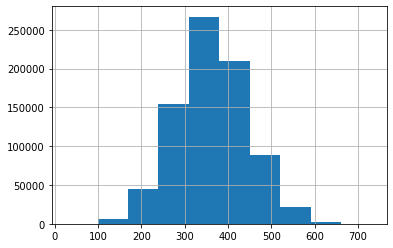

In [65]:
dfnaclean.Dots.hist()

<AxesSubplot:>

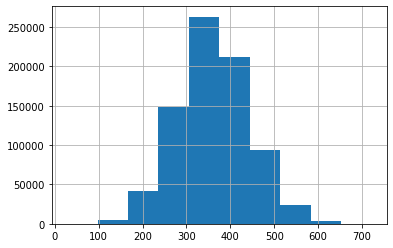

In [66]:
dfnaclean.Wilks.hist()

<AxesSubplot:>

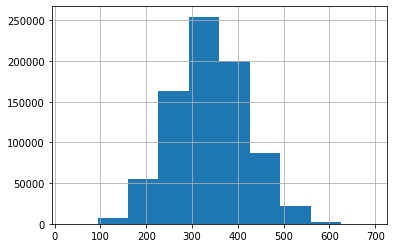

In [67]:
dfnaclean.Glossbrenner.hist()

<AxesSubplot:>

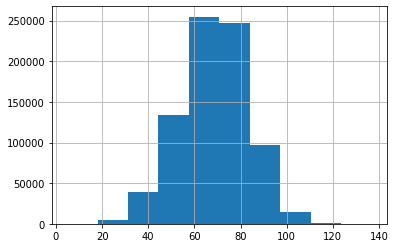

In [68]:
dfnaclean.Goodlift.hist()

<AxesSubplot:>

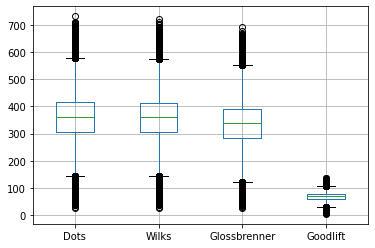

In [69]:
dfnaclean.boxplot(column=['Dots', 'Wilks', 'Glossbrenner', 'Goodlift'])

In [70]:
dfnaclean[(dfnaclean['Dots'] < 580) & (dfnaclean['Dots'] > 150) & (dfnaclean['Wilks'] < 580) & (dfnaclean['Wilks'] > 150) & (dfnaclean['Glossbrenner'] < 550) & (dfnaclean['Glossbrenner'] > 120) & (dfnaclean['Goodlift'] < 110) & (dfnaclean['Goodlift'] > 40)].corr()[['Dots', 'Wilks', 'Glossbrenner', 'Goodlift']]

,Dots,Wilks,Glossbrenner,Goodlift
Sex,0.238388,0.232735,0.395980,0.210158
BodyweightKg,0.181579,0.165614,0.205908,0.217038
Best3SquatKg,0.782216,0.770058,0.825788,0.691040
Best3BenchKg,0.692934,0.681213,0.752580,0.627177
Best3DeadliftKg,0.716569,0.701051,0.772932,0.714247
TotalKg,0.761554,0.747879,0.815823,0.706121
Dots,1.000000,0.997837,0.981844,0.890005
Wilks,0.997837,1.000000,0.983771,0.882805
Glossbrenner,0.981844,0.983771,1.000000,0.865150
Goodlift,0.890005,0.882805,0.865150,1.000000


In [71]:
dfnaclean[(dfnaclean['Dots'] < 580) & (dfnaclean['Dots'] > 150)].corr().Dots

Sex                0.235698
BodyweightKg       0.197990
Best3SquatKg       0.797521
Best3BenchKg       0.706873
Best3DeadliftKg    0.740251
TotalKg            0.779134
Dots               1.000000
Wilks              0.998071
Glossbrenner       0.983764
Goodlift           0.904869
EquipmentC         0.303164
DivisionC          0.135302
WeightClassKgC    -0.078962
PlaceC            -0.026016
NameC              0.014666
EventC                  NaN
Age                0.001523
Name: Dots, dtype: float64

In [72]:
dfnaclean[(dfnaclean['Wilks'] < 580) & (dfnaclean['Wilks'] > 150)].corr().Wilks

Sex                0.230818
BodyweightKg       0.183125
Best3SquatKg       0.787281
Best3BenchKg       0.697074
Best3DeadliftKg    0.726957
TotalKg            0.767526
Dots               0.998081
Wilks              1.000000
Glossbrenner       0.985598
Goodlift           0.898505
EquipmentC         0.310219
DivisionC          0.136180
WeightClassKgC    -0.096685
PlaceC            -0.028066
NameC              0.015714
EventC                  NaN
Age               -0.003702
Name: Wilks, dtype: float64

In [73]:
dfnaclean[(dfnaclean['Glossbrenner'] < 550) & (dfnaclean['Glossbrenner'] > 120)].corr().Glossbrenner

Sex                0.374475
BodyweightKg       0.218211
Best3SquatKg       0.836644
Best3BenchKg       0.760818
Best3DeadliftKg    0.790102
TotalKg            0.827558
Dots               0.983776
Wilks              0.985590
Glossbrenner       1.000000
Goodlift           0.883620
EquipmentC         0.311216
DivisionC          0.162743
WeightClassKgC    -0.100745
PlaceC            -0.009810
NameC              0.017817
EventC                  NaN
Age               -0.008907
Name: Glossbrenner, dtype: float64

In [74]:
dfnaclean[(dfnaclean['Goodlift'] < 110) & (dfnaclean['Goodlift'] > 40)].corr().Goodlift

Sex                0.205670
BodyweightKg       0.214126
Best3SquatKg       0.697136
Best3BenchKg       0.634353
Best3DeadliftKg    0.715514
TotalKg            0.710625
Dots               0.893801
Wilks              0.886811
Glossbrenner       0.870061
Goodlift           1.000000
EquipmentC        -0.080973
DivisionC          0.125268
WeightClassKgC    -0.055251
PlaceC            -0.089062
NameC             -0.000585
EventC                  NaN
Age                0.016831
Name: Goodlift, dtype: float64

##### Testando métodos de remoção de outliers

In [75]:
codes = ['Equipment', 'Division', 'WeightClassKg', 'Place', 'Name', 'Event', 'NameC', 'EventC']
dfclean = dfnaclean.drop(codes, axis = 1).dropna()
dfclean.dtypes

Sex                   int8
BodyweightKg       float64
Best3SquatKg       float64
Best3BenchKg       float64
Best3DeadliftKg    float64
TotalKg            float64
Dots               float64
Wilks              float64
Glossbrenner       float64
Goodlift           float64
EquipmentC            int8
DivisionC            int16
WeightClassKgC       int16
PlaceC                int8
Age                float64
dtype: object

In [76]:
from sklearn.ensemble import IsolationForest
isolFor = IsolationForest(max_samples=100, random_state=42)
isolFor.fit(dfclean)

IsolationForest(max_samples=100, random_state=42)

In [77]:
dfclean['outlierIsol'] = isolFor.predict(dfclean)

In [78]:
dfclean[dfclean['outlierIsol'] != -1].drop('outlierIsol', axis=1).corr()

,Sex,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Dots,Wilks,Glossbrenner,Goodlift,EquipmentC,DivisionC,WeightClassKgC,PlaceC,Age
Sex,1.000000,0.390996,0.644353,0.706850,0.704756,0.716045,0.259845,0.264488,0.454700,0.182293,0.145235,0.203877,-0.097337,0.126343,0.002909
BodyweightKg,0.390996,1.000000,0.595980,0.613623,0.611954,0.635716,0.086494,0.064160,0.105076,0.154484,-0.080098,0.103525,-0.394377,-0.007382,0.169041
Best3SquatKg,0.644353,0.595980,1.000000,0.867517,0.880278,0.964756,0.745488,0.732534,0.795614,0.608291,0.290427,0.192601,-0.181358,0.050818,0.042333
Best3BenchKg,0.706850,0.613623,0.867517,1.000000,0.841921,0.938952,0.640177,0.629197,0.713746,0.544968,0.210047,0.219510,-0.207326,0.045077,0.115693
Best3DeadliftKg,0.704756,0.611954,0.880278,0.841921,1.000000,0.955326,0.672741,0.658946,0.740058,0.649618,0.099263,0.185572,-0.172062,0.034360,0.085379
TotalKg,0.716045,0.635716,0.964756,0.938952,0.955326,1.000000,0.723357,0.710055,0.789158,0.634009,0.210186,0.207223,-0.194327,0.045500,0.081921
Dots,0.259845,0.086494,0.745488,0.640177,0.672741,0.723357,1.000000,0.997540,0.972653,0.833171,0.336379,0.147039,-0.001049,-0.019455,0.003217
Wilks,0.264488,0.064160,0.732534,0.629197,0.658946,0.710055,0.997540,1.000000,0.977650,0.825662,0.340575,0.148567,-0.020248,-0.022076,-0.004844
Glossbrenner,0.454700,0.105076,0.795614,0.713746,0.740058,0.789158,0.972653,0.977650,1.000000,0.792385,0.350381,0.177643,-0.028399,0.007408,-0.011346
Goodlift,0.182293,0.154484,0.608291,0.544968,0.649618,0.634009,0.833171,0.825662,0.792385,1.000000,-0.228408,0.076182,-0.000377,-0.074448,0.040498


In [79]:
# from sklearn.neighbors import LocalOutlierFactor
# localOutlier = LocalOutlierFactor(n_neighbors=10)
# dfclean['outlierLocal'] = localOutlier.fit_predict(dfclean)

In [80]:
# dfclean[dfclean['outlierLocal'] != -1].drop('outlierLocal', axis=1).corr()

#### 4. Hipóteses e testes de hipótese

##### Hipótese 1

In [93]:
dfMan = dfclean[dfclean['Sex'] == 1]
dfWoman = dfclean[dfclean['Sex'] == 0]

In [95]:
dfMan['TotalKgLog'] = dfMan['TotalKg'].apply(np.log10)
dfWoman['TotalKgLog'] = dfWoman['TotalKg'].apply(np.log10)
dfclean['TotalKgLog'] = dfclean['TotalKg'].apply(np.log10)

<ipython-input-95-f39e6dab2861>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfMan['TotalKgLog'] = dfMan['TotalKg'].apply(np.log10)
<ipython-input-95-f39e6dab2861>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfWoman['TotalKgLog'] = dfWoman['TotalKg'].apply(np.log10)


<AxesSubplot:>

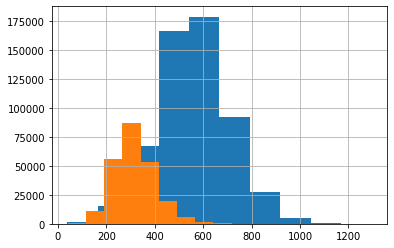

In [108]:
dfMan['TotalKg'].hist()
dfWoman['TotalKg'].hist()

<AxesSubplot:>

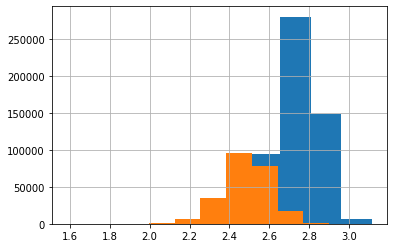

In [96]:
dfMan['TotalKgLog'].hist()
dfWoman['TotalKgLog'].hist()

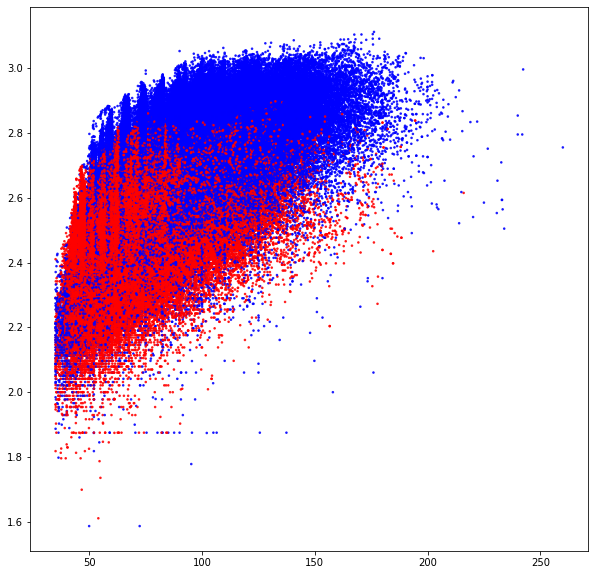

In [101]:
## peso total por peso corporal, separado por genero
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(dfclean['BodyweightKg'], dfclean['TotalKgLog'], alpha=0.8, s=2.5,
           c=['r' if x == 0 else 'b' for x in dfclean['Sex']])

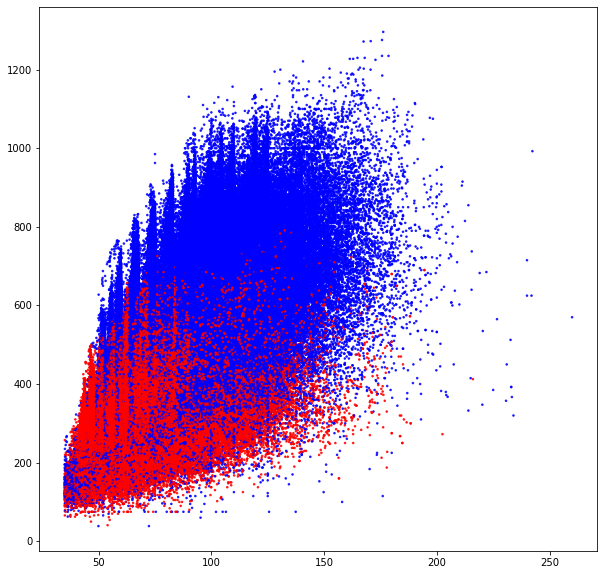

In [83]:
## peso total por peso corporal, separado por genero
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(dfclean['BodyweightKg'], dfclean['TotalKg'], alpha=0.8, s=2.5,
           c=['r' if x == 0 else 'b' for x in dfclean['Sex']])

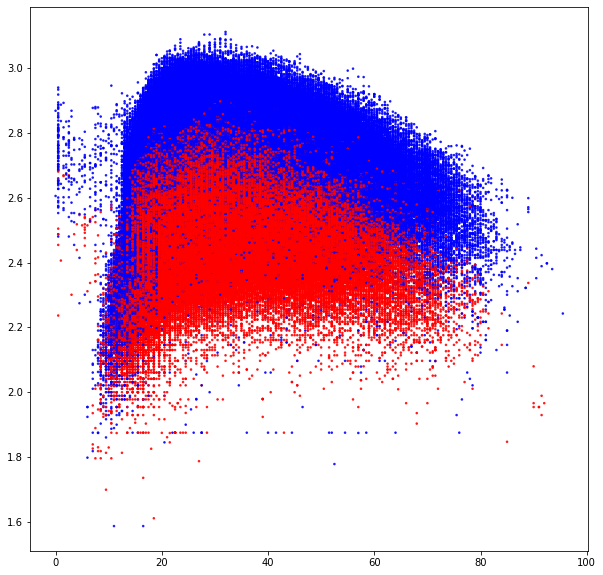

In [102]:
## peso total por idade, separado por genero
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(dfclean['Age'], dfclean['TotalKgLog'], alpha=0.8, s=2.5,
           c=['r' if x == 0 else 'b' for x in dfclean['Sex']])

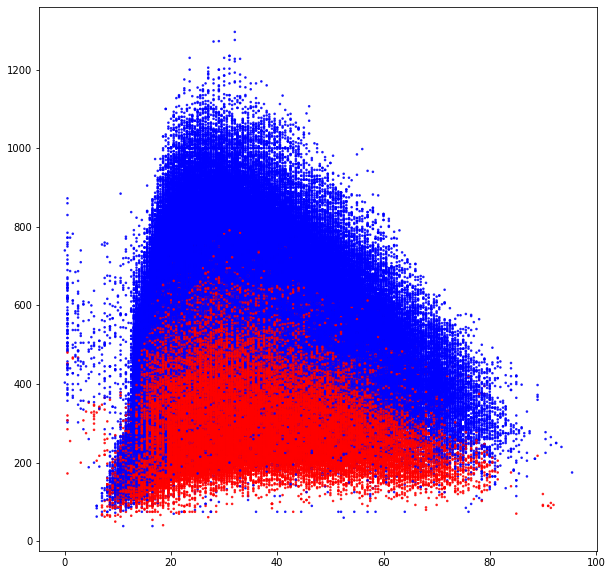

In [86]:
## peso total por idade, separado por genero
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(dfclean['Age'], dfclean['TotalKg'], alpha=0.8, s=2.5,
           c=['r' if x == 0 else 'b' for x in dfclean['Sex']])

In [89]:
stats.ttest_ind(dfWoman['TotalKg'], dfMan['TotalKg'])

Ttest_indResult(statistic=-766.3740482324984, pvalue=0.0)

In [103]:
stats.ttest_ind(dfWoman['TotalKgLog'], dfMan['TotalKgLog'])

Ttest_indResult(statistic=-833.3987807239774, pvalue=0.0)

In [106]:
stats.mannwhitneyu(dfWoman['TotalKg'], dfMan['TotalKg'])

MannwhitneyuResult(statistic=9359376283.0, pvalue=0.0)

In [105]:
stats.mannwhitneyu(dfWoman['TotalKgLog'], dfMan['TotalKgLog'])

MannwhitneyuResult(statistic=9359376283.0, pvalue=0.0)

<AxesSubplot:>

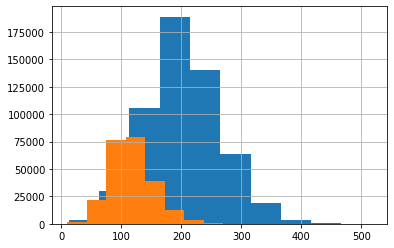

In [111]:
dfMan['Best3SquatKg'].hist()   
dfWoman['Best3SquatKg'].hist()  

<AxesSubplot:>

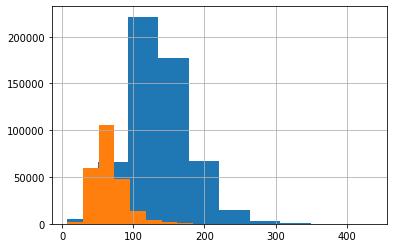

In [112]:
dfMan['Best3BenchKg'].hist()   
dfWoman['Best3BenchKg'].hist()    

<AxesSubplot:>

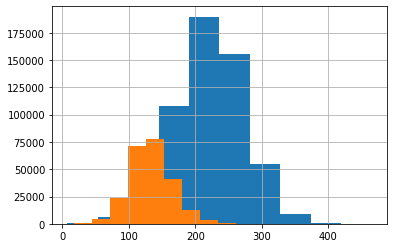

In [113]:
dfMan['Best3DeadliftKg'].hist()   
dfWoman['Best3DeadliftKg'].hist()  

In [114]:
stats.ttest_ind(dfWoman['Best3SquatKg'], dfMan['Best3SquatKg'])

Ttest_indResult(statistic=-649.4221935694288, pvalue=0.0)

In [115]:
stats.mannwhitneyu(dfWoman['Best3SquatKg'], dfMan['Best3SquatKg'])

MannwhitneyuResult(statistic=13616952859.0, pvalue=0.0)

In [116]:
stats.ttest_ind(dfWoman['Best3BenchKg'], dfMan['Best3BenchKg'])

Ttest_indResult(statistic=-769.1100759801766, pvalue=0.0)

In [117]:
stats.mannwhitneyu(dfWoman['Best3BenchKg'], dfMan['Best3BenchKg'])

MannwhitneyuResult(statistic=7988686524.0, pvalue=0.0)

In [118]:
stats.ttest_ind(dfWoman['Best3DeadliftKg'], dfMan['Best3DeadliftKg'])

Ttest_indResult(statistic=-777.810144053493, pvalue=0.0)

In [130]:
stats.mannwhitneyu(dfWoman['Best3DeadliftKg'], dfMan['Best3DeadliftKg'])

Ttest_indResult(statistic=-961.4774799439207, pvalue=0.0)

In [128]:
stats.ttest_ind(dfMan['Best3BenchKg'], dfMan['Best3DeadliftKg'])

Ttest_indResult(statistic=-961.4774799439207, pvalue=0.0)

##### Hipótese 2

<AxesSubplot:>

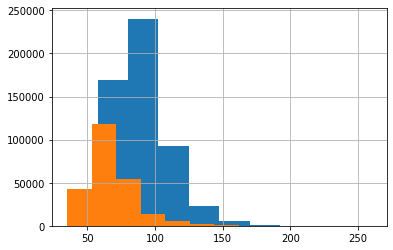

In [129]:
dfMan['BodyweightKg'].hist()   
dfWoman['BodyweightKg'].hist()  

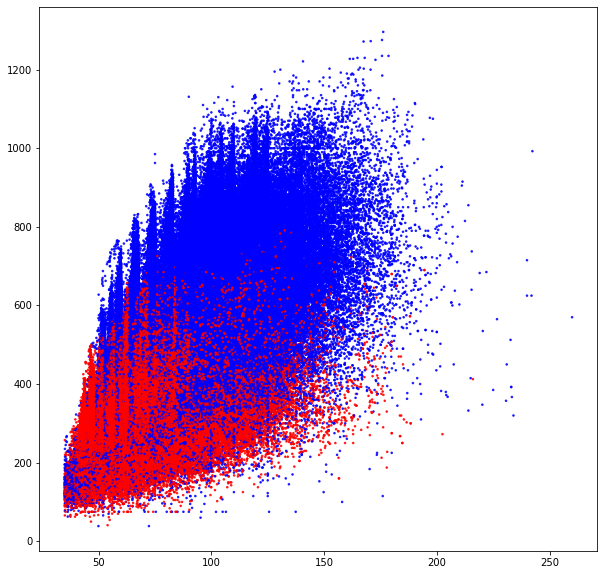

In [109]:
## peso total por peso corporal, separado por genero
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(dfclean['BodyweightKg'], dfclean['TotalKg'], alpha=0.8, s=2.5,
           c=['r' if x == 0 else 'b' for x in dfclean['Sex']])

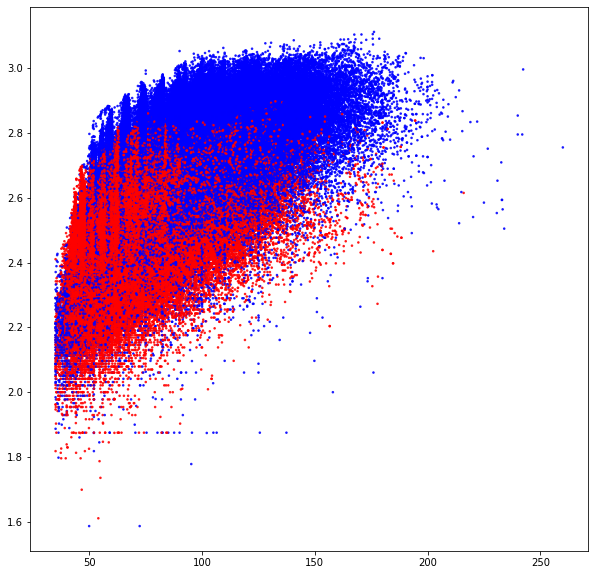

In [110]:
## peso total por peso corporal, separado por genero
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(dfclean['BodyweightKg'], dfclean['TotalKgLog'], alpha=0.8, s=2.5,
           c=['r' if x == 0 else 'b' for x in dfclean['Sex']])

In [131]:
stats.mannwhitneyu(dfWoman['BodyweightKg'], dfMan['BodyweightKg'])

MannwhitneyuResult(statistic=25628473734.0, pvalue=0.0)

In [132]:
stats.ttest_ind(dfWoman['BodyweightKg'], dfMan['BodyweightKg'])

Ttest_indResult(statistic=-432.9983249609491, pvalue=0.0)

##### Hipótese 3

In [135]:
dfclean['EquipmentC'].value_counts()

0    477433
1    313196
Name: EquipmentC, dtype: int64

In [137]:
df0 = dfclean[dfclean['EquipmentC'] == 0]
df1 = dfclean[dfclean['EquipmentC'] == 1]

<AxesSubplot:>

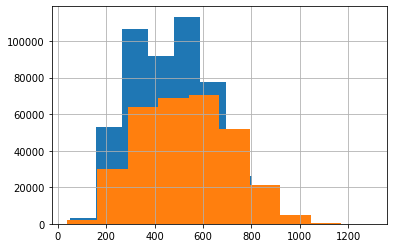

In [138]:
df0['TotalKg'].hist()
df1['TotalKg'].hist()

<AxesSubplot:>

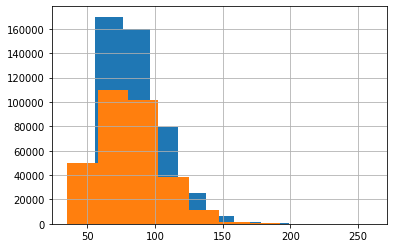

In [139]:
df0['BodyweightKg'].hist()
df1['BodyweightKg'].hist()

<AxesSubplot:>

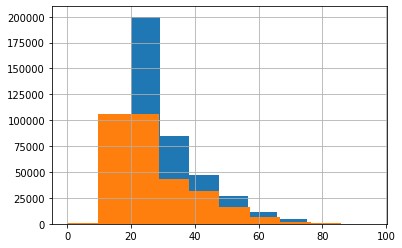

In [140]:
df0['Age'].hist()
df1['Age'].hist()

<AxesSubplot:>

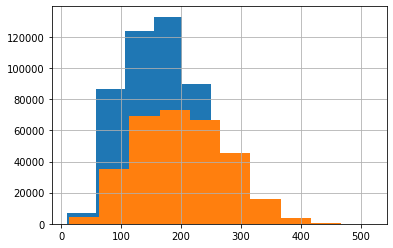

In [157]:
df0['Best3SquatKg'].hist()
df1['Best3SquatKg'].hist()

<AxesSubplot:>

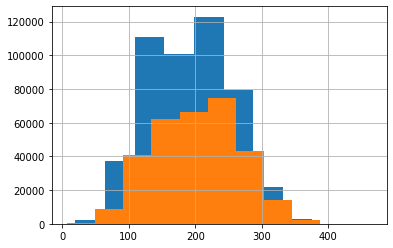

In [158]:
df0['Best3DeadliftKg'].hist()
df1['Best3DeadliftKg'].hist()

<AxesSubplot:>

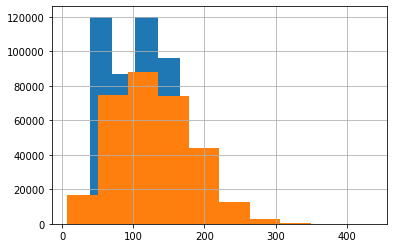

In [159]:
df0['Best3BenchKg'].hist()
df1['Best3BenchKg'].hist()

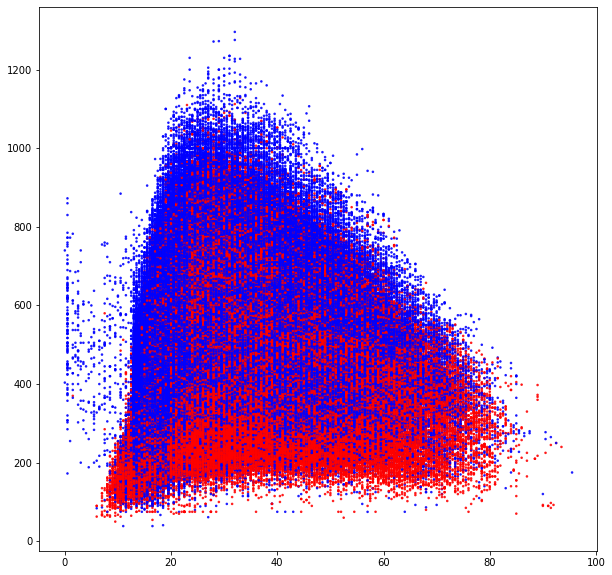

In [141]:
## peso total por idade, separado por genero
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(dfclean['Age'], dfclean['TotalKg'], alpha=0.8, s=2.5,
           c=['r' if x == 0 else 'b' for x in dfclean['EquipmentC']])

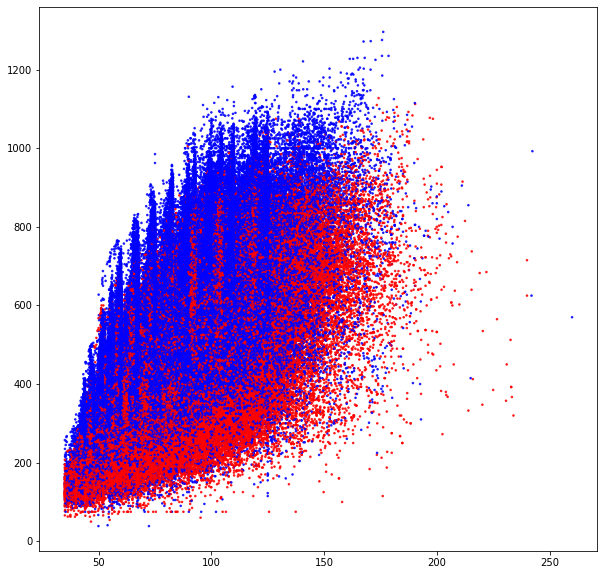

In [142]:
## peso total por peso corporal, separado por genero
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(dfclean['BodyweightKg'], dfclean['TotalKg'], alpha=0.8, s=2.5,
           c=['r' if x == 0 else 'b' for x in dfclean['EquipmentC']])

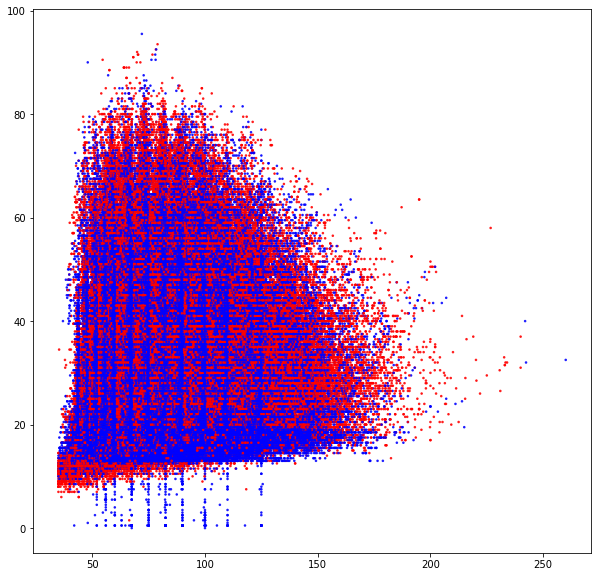

In [143]:
## peso total por peso corporal, separado por genero
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(dfclean['BodyweightKg'], dfclean['Age'], alpha=0.8, s=2.5,
           c=['r' if x == 0 else 'b' for x in dfclean['EquipmentC']])

In [151]:
stats.ttest_ind(df0['TotalKgLog'], df1['TotalKgLog'])

Ttest_indResult(statistic=-158.18860379365466, pvalue=0.0)

In [145]:
stats.ttest_ind(df0['BodyweightKg'], df1['BodyweightKg'])

Ttest_indResult(statistic=38.694771694802114, pvalue=0.0)

In [146]:
stats.ttest_ind(df0['Age'], df1['Age'])

Ttest_indResult(statistic=72.34983158605799, pvalue=0.0)

In [160]:
stats.ttest_ind(df0['Best3SquatKg'], df1['Best3SquatKg'])

Ttest_indResult(statistic=-247.92308065155623, pvalue=0.0)

In [161]:
stats.ttest_ind(df0['Best3DeadliftKg'], df1['Best3DeadliftKg'])

Ttest_indResult(statistic=-86.49658726158971, pvalue=0.0)

In [162]:
stats.ttest_ind(df0['Best3BenchKg'], df1['Best3BenchKg'])

Ttest_indResult(statistic=-190.95992531981054, pvalue=0.0)